In [201]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(15,5)})

###  Preprocess

Read files

In [202]:
users = pd.read_csv('Calibrated Predictions Survey - users.csv', index_col='id')
preds = pd.read_csv('Calibrated Predictions Survey - predictions.csv', index_col='id')
labels = pd.read_csv('Calibrated Predictions Survey - labels.csv', index_col='id')
pred_test = pd.read_csv('Calibrated Predictions Survey - pred_test.csv', index_col='id')
label_test = pd.read_csv('Calibrated Predictions Survey - outcome_test.csv', index_col='id')
first_rate = pd.read_csv('Calibrated Predictions Survey - first_rate.csv', index_col='id')
last_rate = pd.read_csv('Calibrated Predictions Survey - last_rate.csv', index_col='id')

Replace values in data

In [203]:
preds_outcome = preds.applymap(lambda x: 1 if x > 50 else 0)

map = {"Yes": 1, "No": 0}
label_test = label_test.applymap(lambda x: map.get(x, -1))

Get every model indexes

In [204]:
models_names = users['model_name'].unique()
model_indexes = {}

# get indexes of every model name
for model in models_names:
    model_indexes[model] = users.index[users['model_name'] == model].tolist()

### Average user trust in the system

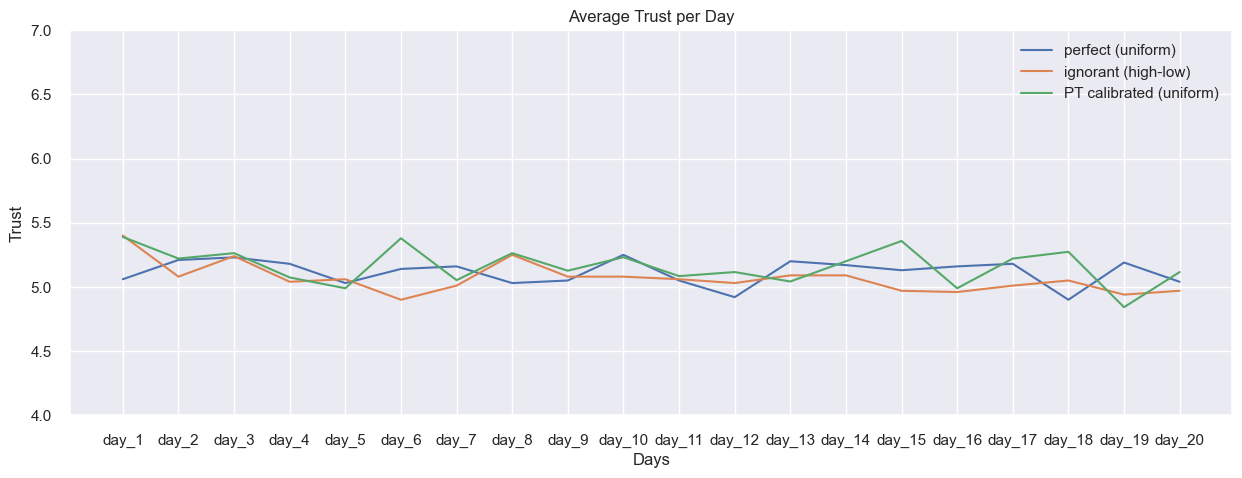

In [205]:
# calculate and plot average trust per day for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes[model]]
    last_rate_model_mean = last_rate_model.mean()
    p = sns.lineplot(x=last_rate.columns, y=last_rate_model_mean, 
                     dashes=False, markers=True, label=model)

p.set(ylim=(4, 7), title='Average Trust per Day', ylabel='Trust', xlabel='Days')
plt.show()

### User actions according to system predictions

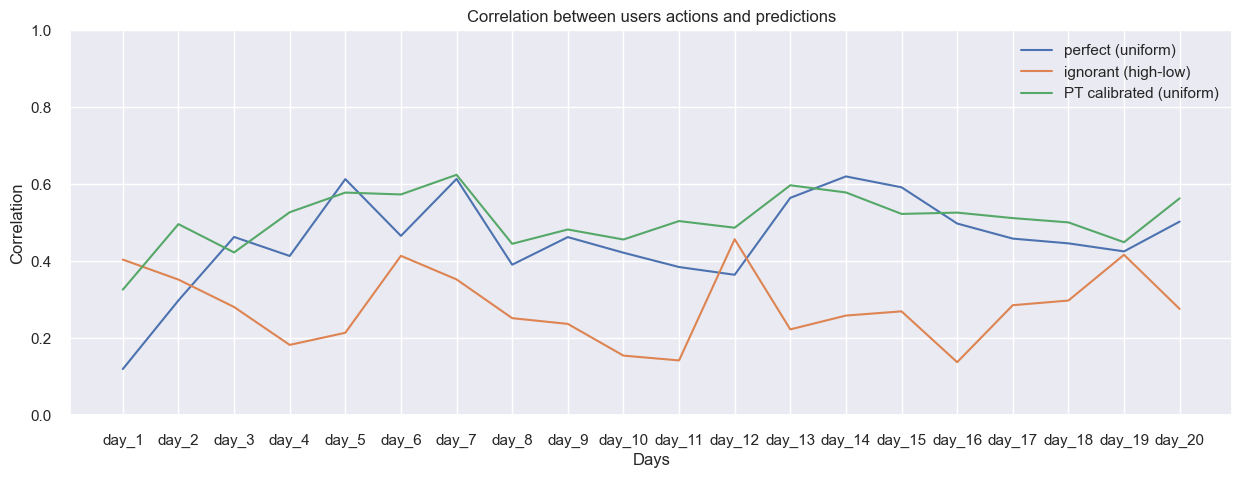

In [206]:
# calculate and plot correlation between model prediction and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes[model]]
    first_rate_model = first_rate.loc[model_indexes[model]]
    cors = preds_model.corrwith(first_rate_model, method='pearson')
    p = sns.lineplot(x=cors.index, y=cors, dashes=False, markers=True, label=model)

p.set(ylim=(0,1), title='Correlation between users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

### Participants Errors

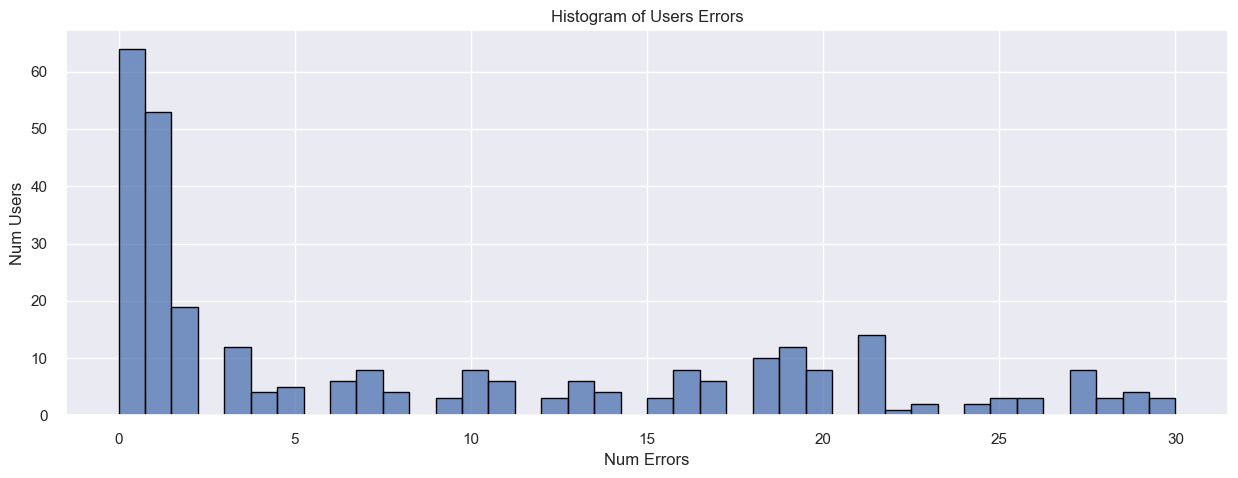

In [207]:
# calculate participants' errors
users_label_error = (labels != label_test).sum(axis=1)
users_pred_error = pred_test.apply(lambda x: (abs(x - preds.loc[x.name]) > 5).sum(), axis=1)
users_error = users_label_error + users_pred_error

# plot histogram of participants' error
p = sns.histplot(users_error, bins=40, edgecolor='black')
p.set(title='Histogram of Users Errors', xlabel='Num Errors', ylabel='Num Users')
plt.show()

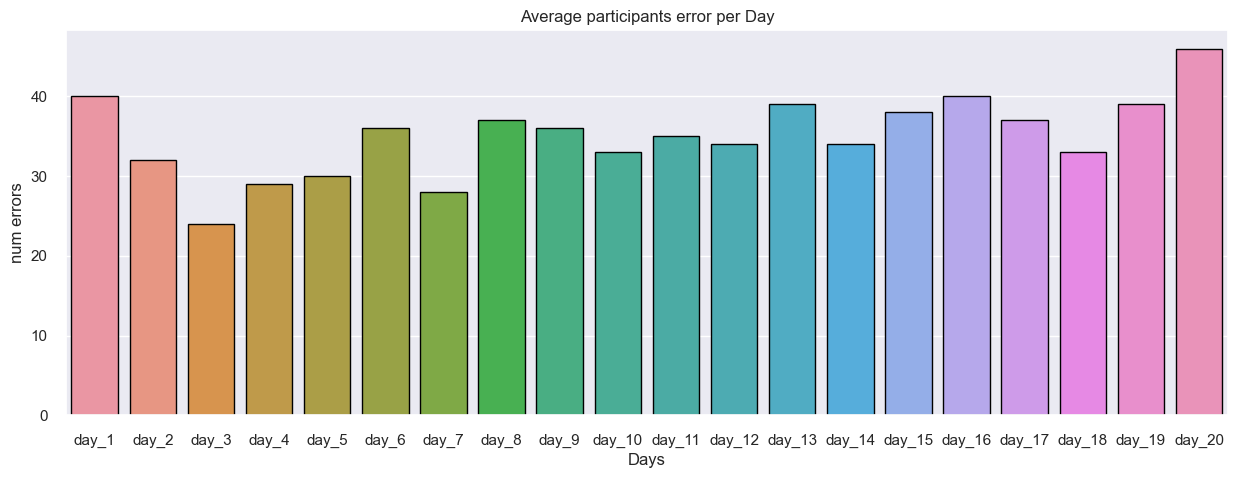

In [208]:
# calculate participants' errors per day
users_label_error_per_day = (labels != label_test).sum(axis=0)
users_pred_error_per_day = pred_test.apply(lambda x: (abs(x - preds.loc[x.name]) > 5), axis=1).sum(axis=0)
users_error_per_day = users_label_error_per_day

# plot participants' error per day
p = sns.barplot(x=users_error_per_day.index, y=users_error_per_day.values, edgecolor='black')
p.set(title='Average participants error per Day', ylabel='num errors', xlabel='Days')
plt.show()

### Analysis of good participants

In [209]:
allowed_errors = 5
days = 20

good_users_idx = users_error[users_error < allowed_errors].index
print(f'Number of users with less than {allowed_errors} errors: {len(good_users_idx)}')

Number of users with less than 5 errors: 152


Get every model indexes

In [210]:
# get good users
users_good = users.loc[good_users_idx]
model_indexes_good = {}

# get indexes of every model name
for model in models_names:
    model_indexes_good[model] = users_good.index[users_good['model_name'] == model].tolist()

Average user trust in the system

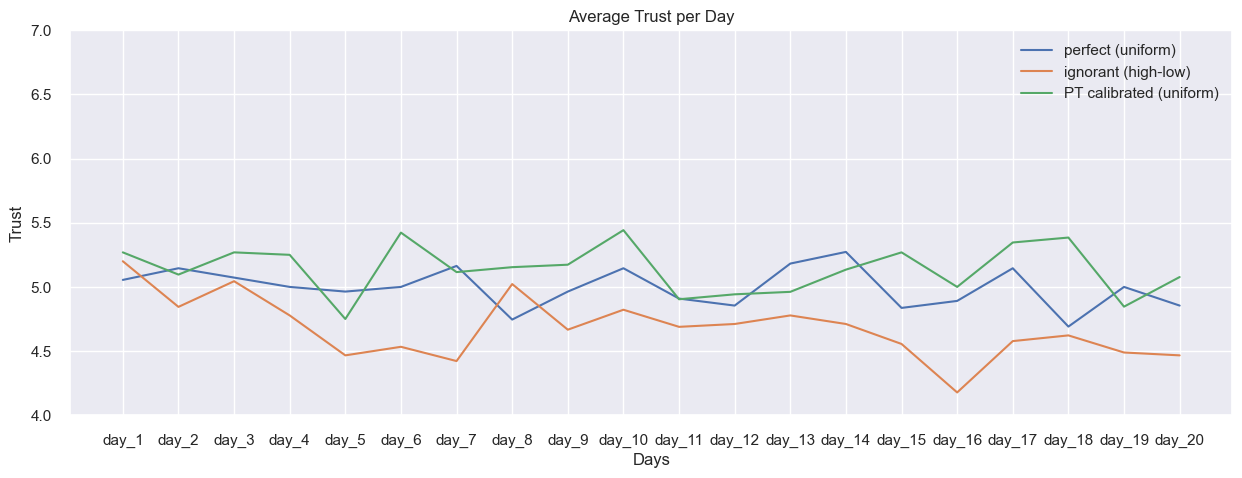

In [211]:
# calculate and plot average trust per day for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes_good[model]]
    last_rate_model_mean = last_rate_model.mean()
    p = sns.lineplot(x=last_rate.columns[:days], y=last_rate_model_mean[:days], 
                     dashes=False, markers=True, label=model)
    
p.set(ylim=(4, 7), title='Average Trust per Day', ylabel='Trust', xlabel='Days')
plt.show()

User actions according to system predictions

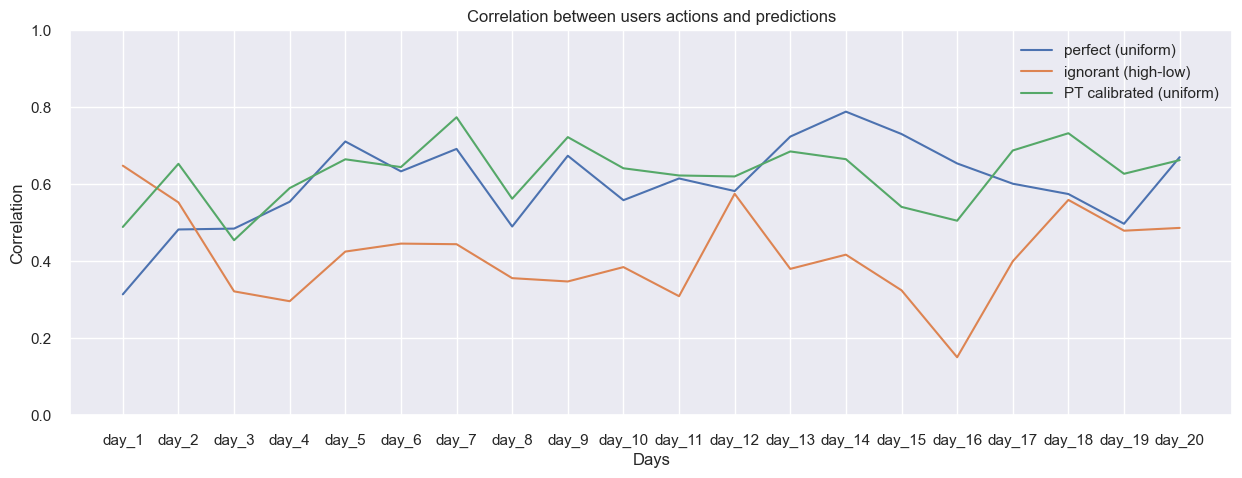

In [212]:
# calculate and plot correlation between model prediction and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes_good[model]]
    first_rate_model = first_rate.loc[model_indexes_good[model]]
    cors = preds_model.corrwith(first_rate_model, method='pearson')
    p = sns.lineplot(x=cors.index[:days], y=cors[:days], dashes=False, markers=True, label=model)

p.set(ylim=(0,1), title='Correlation between users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

### Check statistical significance on correlations

In [213]:
cors = pd.DataFrame(columns=models_names)

# create dataframe of correlations between model predictions and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes[model]]
    first_rate_model = first_rate.loc[model_indexes[model]]
    cors[model] = preds_model.corrwith(first_rate_model, method='pearson')

# select days to analyze
start_day = 1
end_day = 20
cors = cors.iloc[start_day:end_day]
# print(cors)

In [214]:
# check statistical significance between models with t-test
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        ttest = ttest_ind(cors[model1], cors[model2])
        print(f'{model1} vs {model2}: {ttest}')

perfect (uniform) vs ignorant (high-low): Ttest_indResult(statistic=6.690783603541544, pvalue=8.383292157691368e-08)
perfect (uniform) vs PT calibrated (uniform): Ttest_indResult(statistic=-1.8084804967515153, pvalue=0.07889092249357912)
ignorant (high-low) vs PT calibrated (uniform): Ttest_indResult(statistic=-9.8691919324413, pvalue=8.821126612788929e-12)
